In [1]:
from activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, activation_triggered_average, normalizeZeroOne, get_input_output_shape
from models.model_builder import load_model
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets

import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchinfo import summary
import numpy as np
from util import fit_gabor_filter
from skimage.transform import hough_line, hough_line_peaks
from skimage.morphology import skeletonize
from skimage.filters import sobel, sato, frangi, hessian, meijering
from skimage.feature import canny
from util import weighted_hough_line

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [3]:
model = load_model("../models/lindsey32grey")
transf = [transforms.ToTensor()]
in_channels = model.in_channels
img_size = model.img_size
if in_channels==1:
    transf.append(transforms.Grayscale())
if img_size != 32:
    transf.append(transforms.Resize((img_size, img_size), antialias=True))

train_data = datasets.CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose(transf))
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)

model = model.get_sequential()
model.to(device)
summary(model, (1,in_channels,img_size,img_size))

Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           2,624
├─ReLU: 1-2                              [1, 32, 32, 32]           --
├─Conv2d: 1-3                            [1, 32, 32, 32]           82,976
├─ReLU: 1-4                              [1, 32, 32, 32]           --
├─Conv2d: 1-5                            [1, 32, 32, 32]           82,976
├─ReLU: 1-6                              [1, 32, 32, 32]           --
├─Conv2d: 1-7                            [1, 32, 32, 32]           82,976
├─ReLU: 1-8                              [1, 32, 32, 32]           --
├─Flatten: 1-9                           [1, 32768]                --
├─Linear: 1-10                           [1, 1024]                 33,555,456
├─ReLU: 1-11                             [1, 1024]                 --
├─Linear: 1-12                           [1, 10]              

In [4]:

conv_test1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels,16,3))
conv_test2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels,in_channels,11,groups=in_channels), torch.nn.Conv2d(in_channels, 16, 1))
summary1 = summary(conv_test1, (1,in_channels, 120, 160))
summary2 = summary(conv_test2, (1,in_channels, 120, 160))

print(summary1.total_mult_adds, summary2.total_mult_adds)

2983040 2541000


## Intermediate Representation

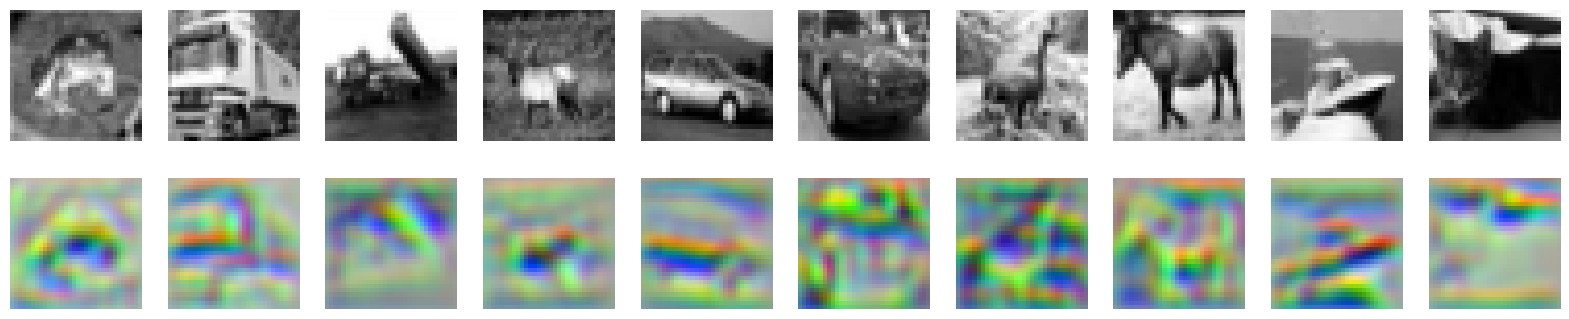

In [5]:
imgs = next(iter(train_loader))
processed = model[:5](imgs[0].to(device)).cpu().detach()

fig, axes = plt.subplots(2, 10, figsize=(20,4))
for ax, im in zip(axes[0], imgs[0]):
    ax.imshow(im.movedim(0,2), cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], processed):
    ax.imshow(normalizeZeroOne(im[:min(3, im.shape[0])].movedim(0,2)), cmap='gray')
    ax.axis('off')

## Receptive Fields

100%|██████████| 32/32 [00:00<00:00, 162.54it/s]


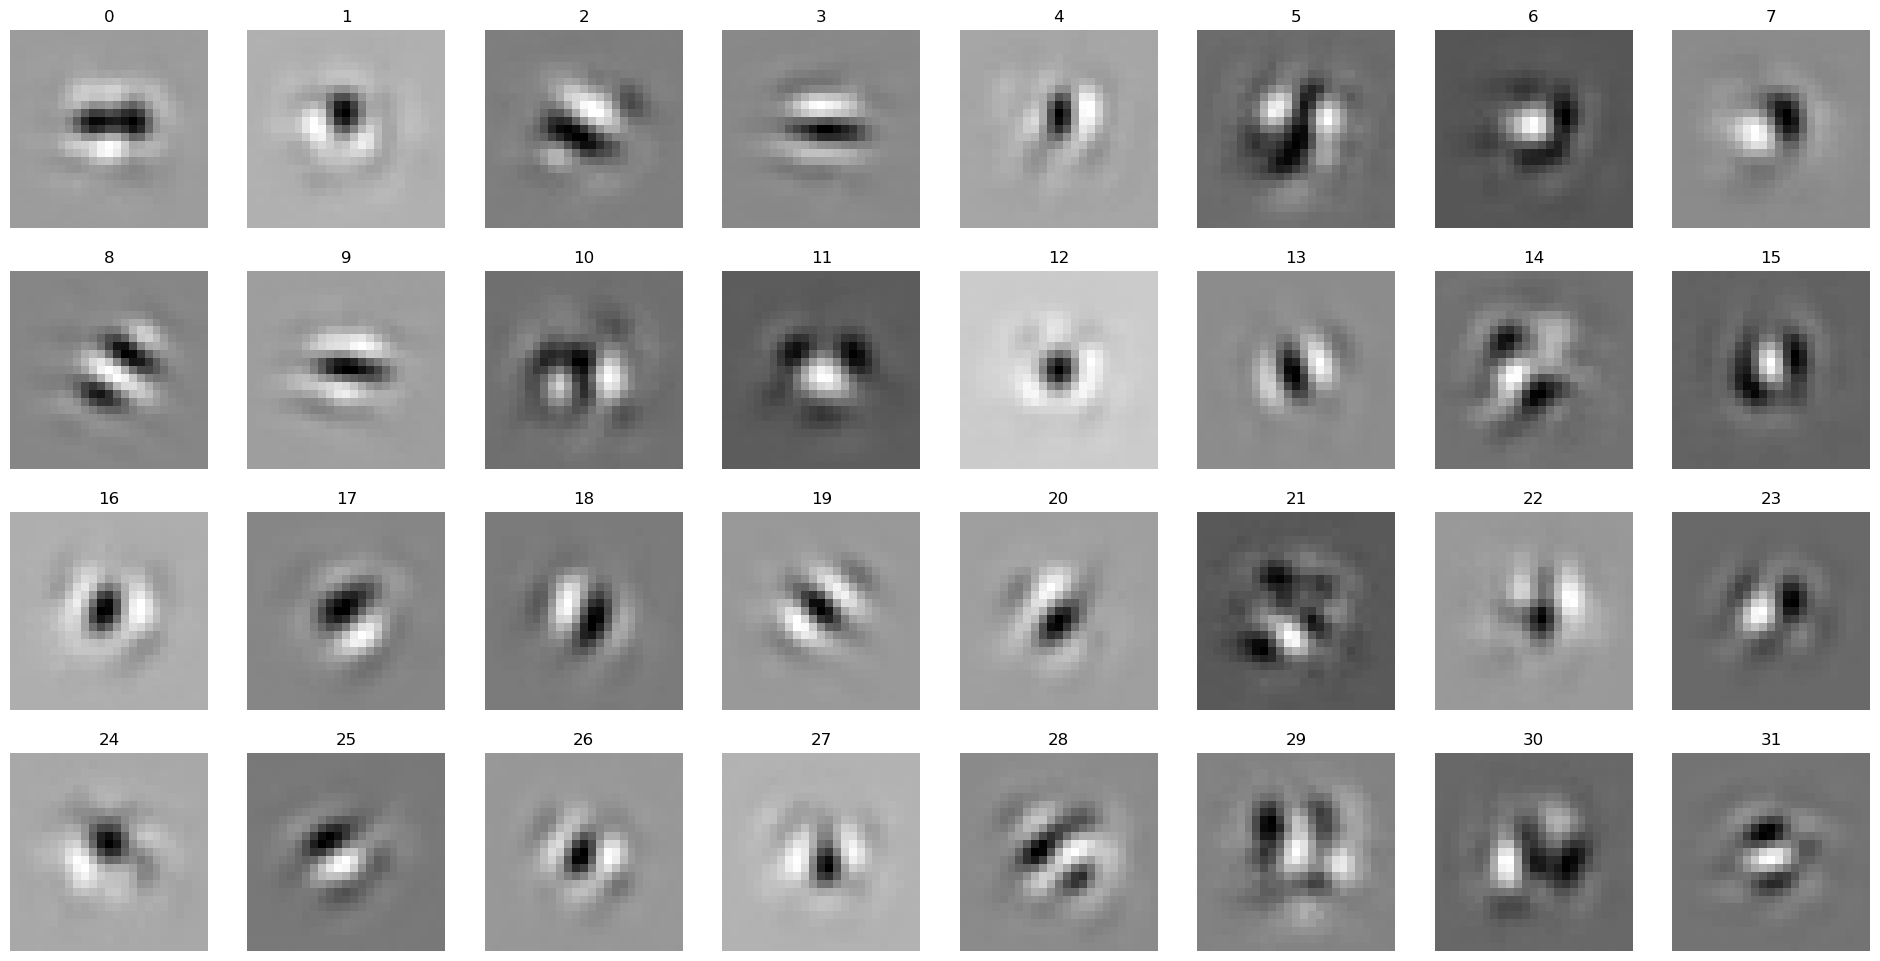

In [6]:
eff_rfs = effective_receptive_field(model[:5], n_batch=1, fill_value=0.5, device=device)  # TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
eff_rfs = eff_rfs.flatten(0,1)
if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    num_rows = max(1,len(eff_rfs)//8)
    fig, axes = plt.subplots(num_rows, 8, figsize=(24,num_rows*3))
    for i, (eff_rf, ax) in enumerate(zip(eff_rfs, axes.flat)):
        ax.imshow(eff_rf, cmap="gray")
        ax.set_title(str(i))
        ax.axis('off')

In [7]:
def plot_hough(image, h, theta, d, rf_edges, hpeaks):
    # Generating figure 1
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    ax = axes.ravel()

    angle_step = 0.5 * np.diff(theta).mean()
    d_step = 0.5 * np.diff(d).mean()
    bounds = [np.rad2deg(theta[0] - angle_step),
            np.rad2deg(theta[-1] + angle_step),
            d[-1] + d_step, d[0] - d_step]
    ax[0].imshow(h, extent=bounds)
    ax[0].set_title('Hough transform')
    ax[0].set_xlabel('Angles (degrees)')
    ax[0].set_ylabel('Distance (pixels)')
    ax[0].axis('image')

    ax[1].imshow(image, cmap='gray')
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Detected lines')

    ax[2].imshow(rf_edges, cmap='gray')
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Edges')

    for _, angle, dist in zip(*hpeaks):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        slope = np.tan(angle + np.pi/2)
        ax[1].axline((x0, y0), slope=slope)
        ax[2].axline((x0, y0), slope=slope)

    plt.tight_layout()
    plt.show()

[-0.25833333]


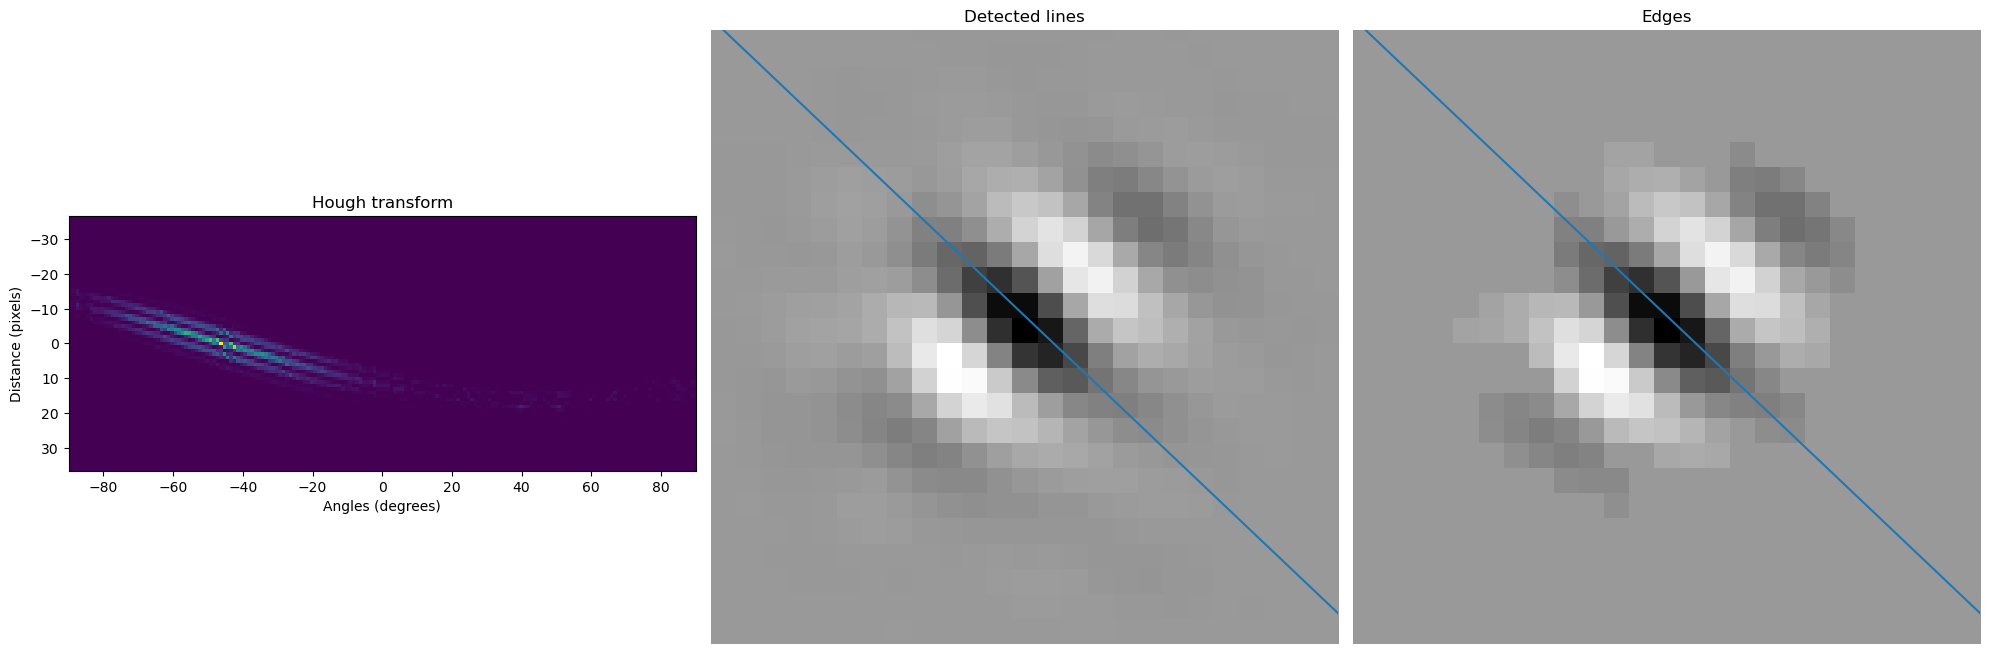

In [8]:
image = eff_rfs[19]
rf_edges = np.zeros_like(image)
rf_edges[:] = image.numpy()#sobel(image.numpy())
rf_edges[np.abs(rf_edges)<np.mean(np.abs(rf_edges))]=0
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges_pos = rf_edges

# rf_edges = sobel(-image.numpy())
# rf_edges = skeletonize(rf_edges > 0.5*rf_edges.max())
# rf_edges = rf_edges + rf_edges_pos

# rf_edges_nms = torch.max_pool2d(torch.from_numpy(rf_edges)[None], kernel_size=3, stride=1, padding=1).numpy()
# rf_edges = rf_edges_nms[0]
n_thetas = 180
thetas = (np.array([i+0.5 for i in range(n_thetas)])/n_thetas*2*np.pi - np.pi)/2
h, theta, d = weighted_hough_line(rf_edges, theta=thetas)
h=h**2
hpeaks = hough_line_peaks(h, theta, d, num_peaks=1) # TODO: Use probabilistic Hough line for connected lines?
print(hpeaks[1]/np.pi)

plot_hough(image, h, theta, d, rf_edges, hpeaks)

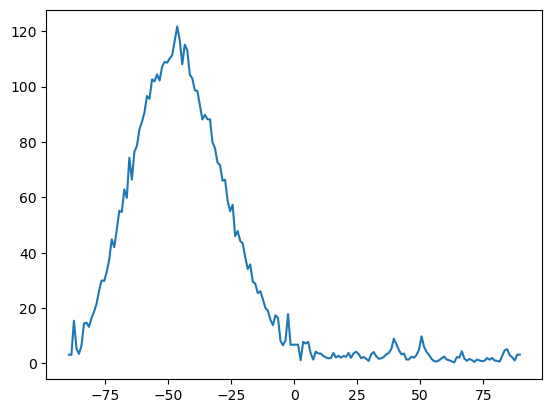

In [9]:
plt.plot(thetas/np.pi*180,(h).sum(axis=0))
plt.show()

The following cell should be run only with a GPU backend!

Other than that, it seems that the activation triggered average results in 'nicer' RFs for the first layer, in higher layers the effective receptive fields are usually smoother (and a lot faster!)

In [10]:
cmap = plt.get_cmap('viridis_r')

0it [00:00, ?it/s]

NameError: name 'eff_rf' is not defined

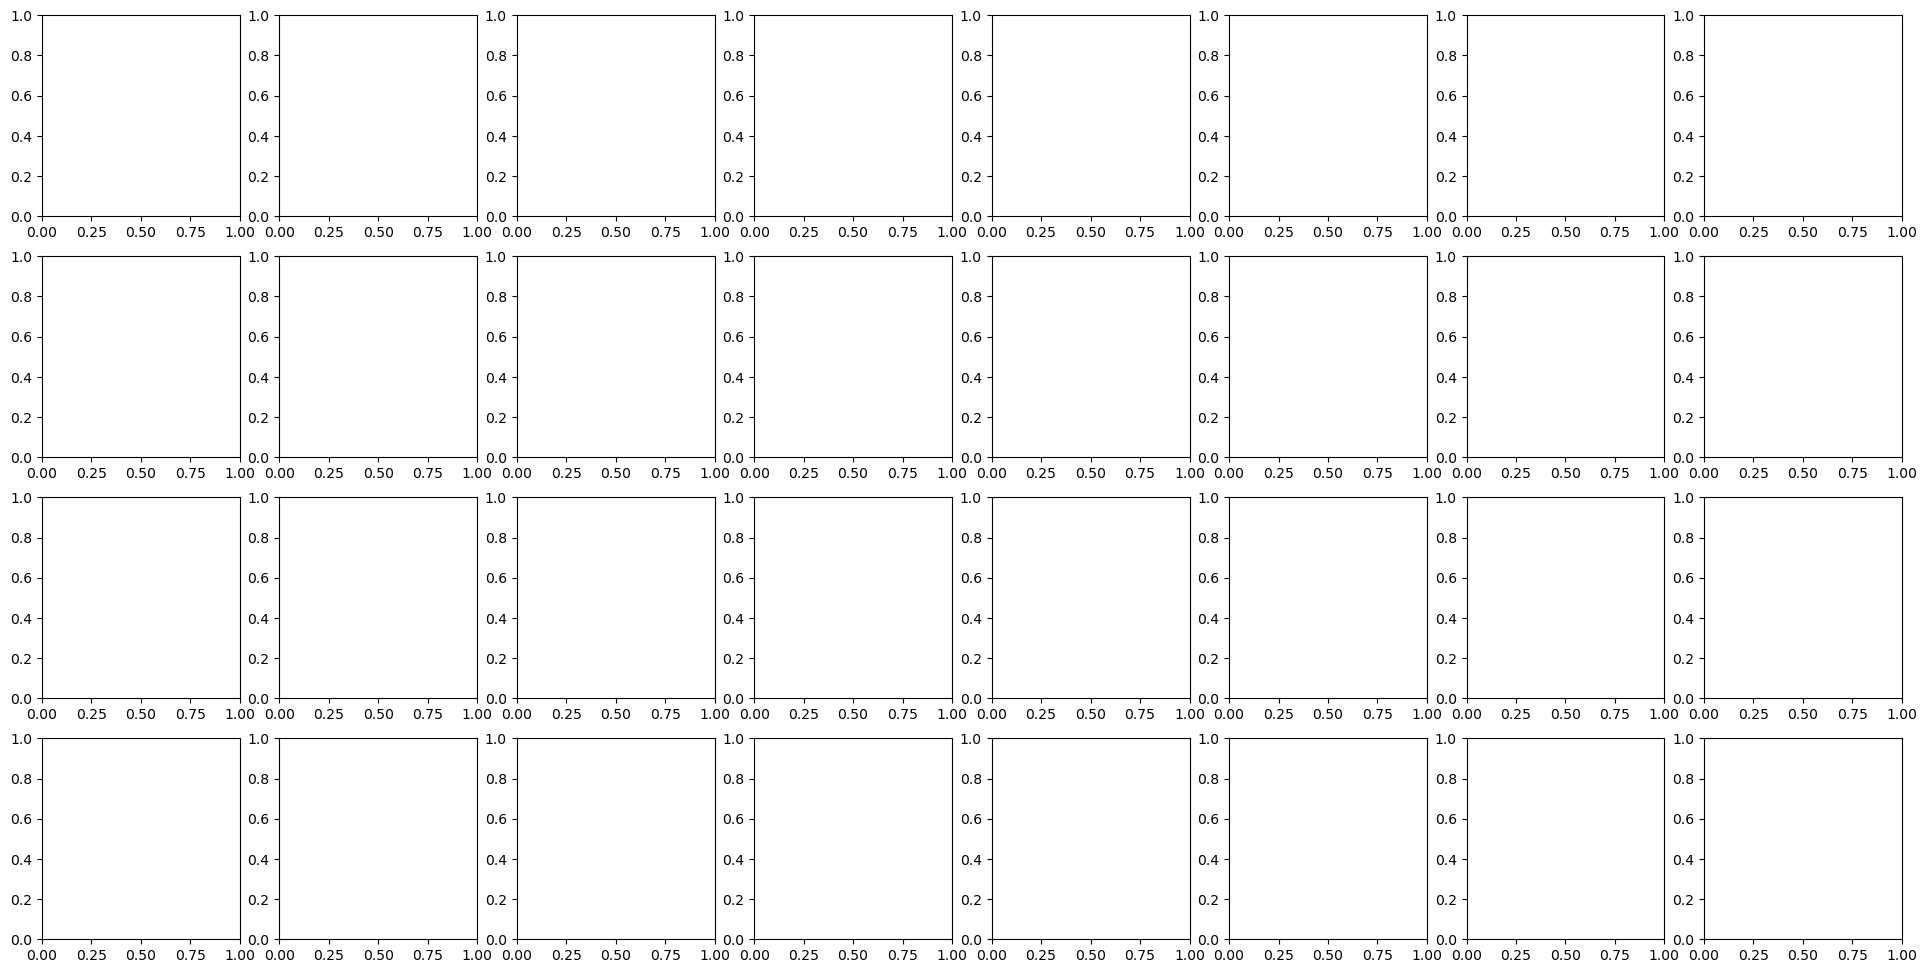

In [11]:
num_rows = max(1,len(eff_rfs)//8)
fig, axes = plt.subplots(num_rows, 8, figsize=(24,num_rows*3))
all_fitted=[]
for eff_rf, ax in tqdm(zip(eff_rfs, axes.flat)):
    fitted = fit_gabor_filter(eff_rf.numpy(), wavelength=8, maxiter=1000)
    all_fitted.append(fitted)
    ax.imshow(fitted[0], cmap="gray")
    ax.set_title('{:.1e}'.format(fitted[1]), color=cmap(fitted[1]/0.005))
    ax.axis('off')

100%|██████████| 32/32 [06:18<00:00, 11.83s/it]


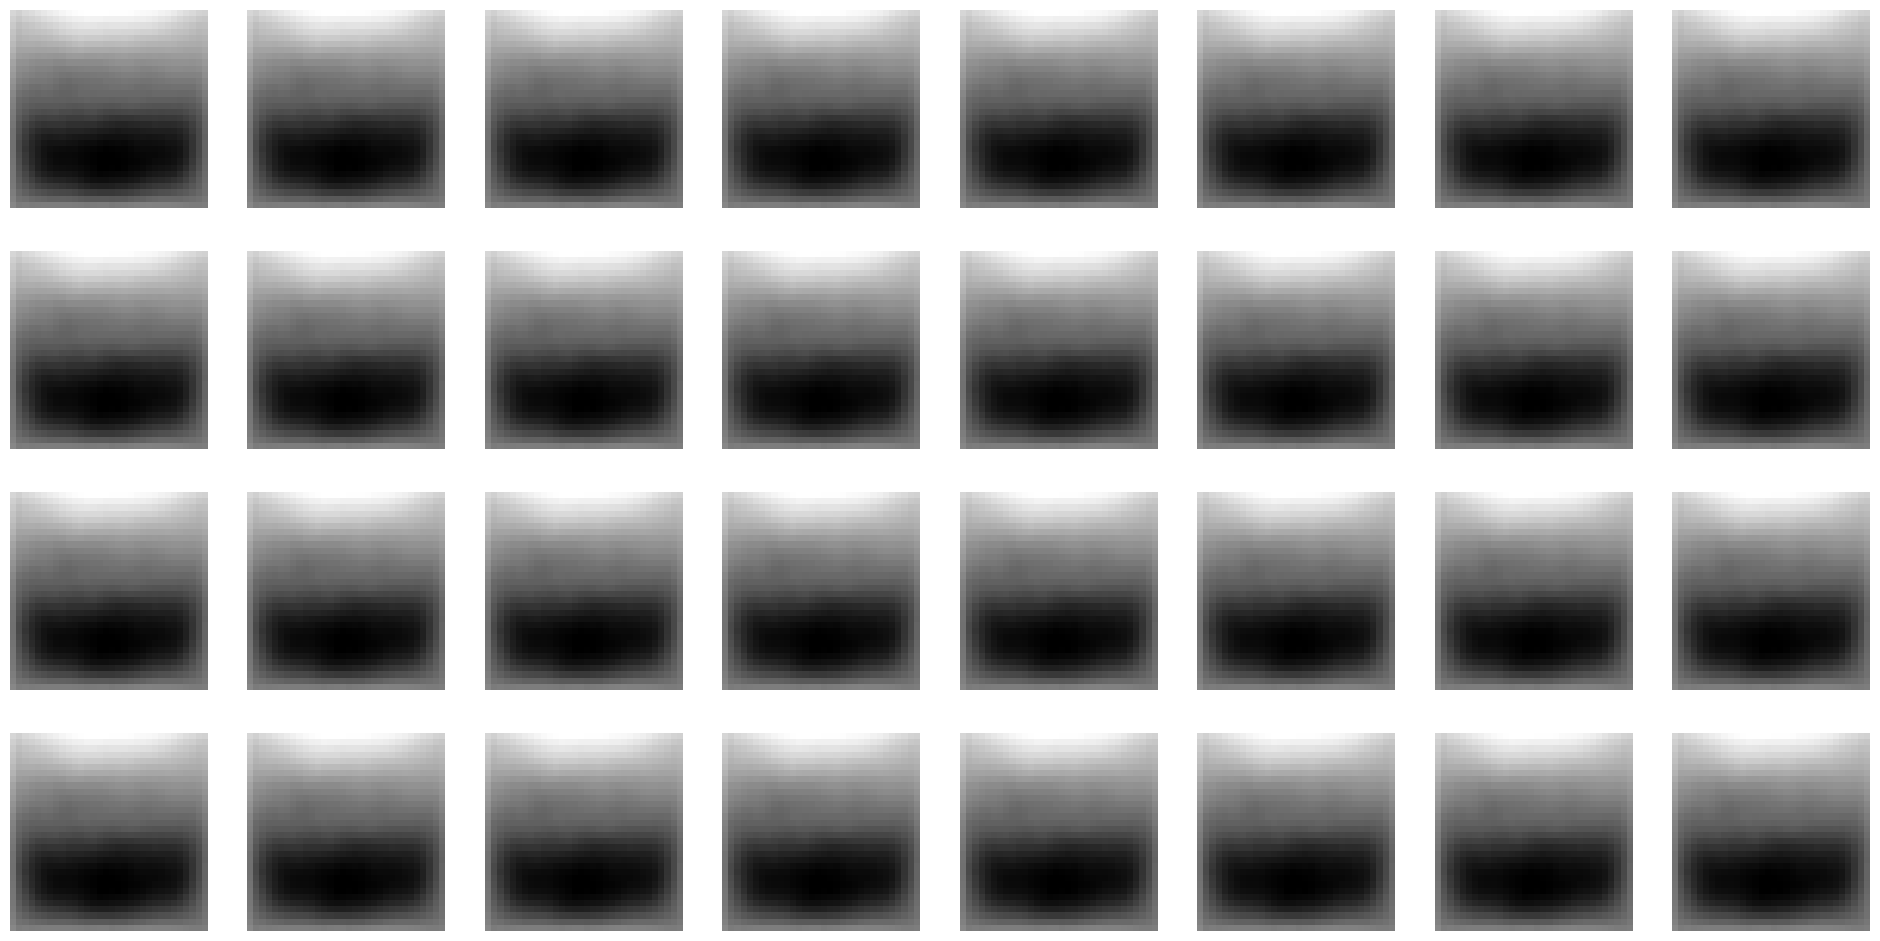

In [8]:
eff_rfs = dataset_average(model[:5], train_loader, device=device) # TODO: Also buggy? :D

if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    fig, axes = plt.subplots(4, 8, figsize=(24,12))
    for eff_rf, ax in zip(eff_rfs, axes.flat):
        ax.imshow(torch.mean(eff_rf, dim=0), cmap="gray")
        ax.axis('off')

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


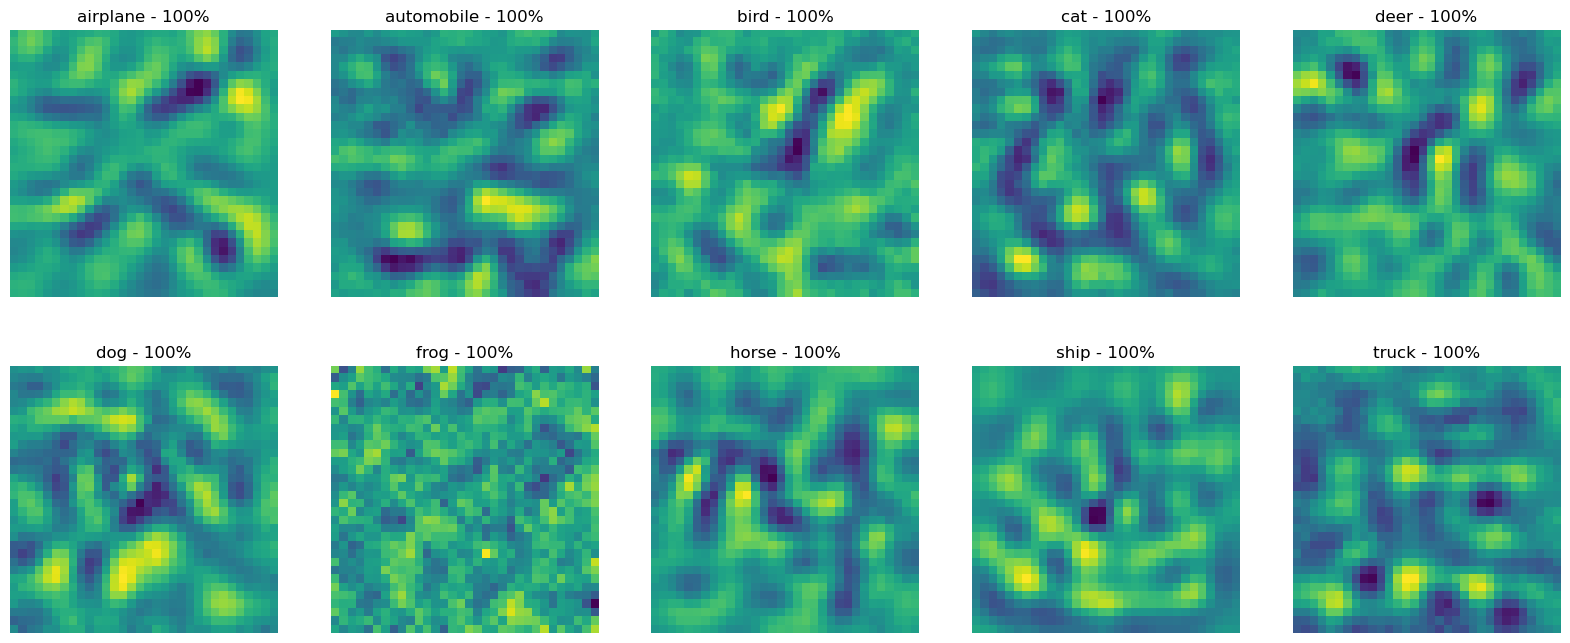

In [9]:
back_maxs = backprop_maximization(model[:-1], n_iter=128, batch_size=1, reduction=True, smoothened=True, device=device)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, back_max, ax in zip(train_data.classes, back_maxs, axes.flat):
    out = model(back_max.repeat(1,1,1,1).to(device))
    index = out.argmax()
    prob = out.max()

    ax.imshow(back_max.movedim(0,2).cpu())
    ax.axis('off')
    ax.set_title(class_name + " - {0:.0%}".format(prob))

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


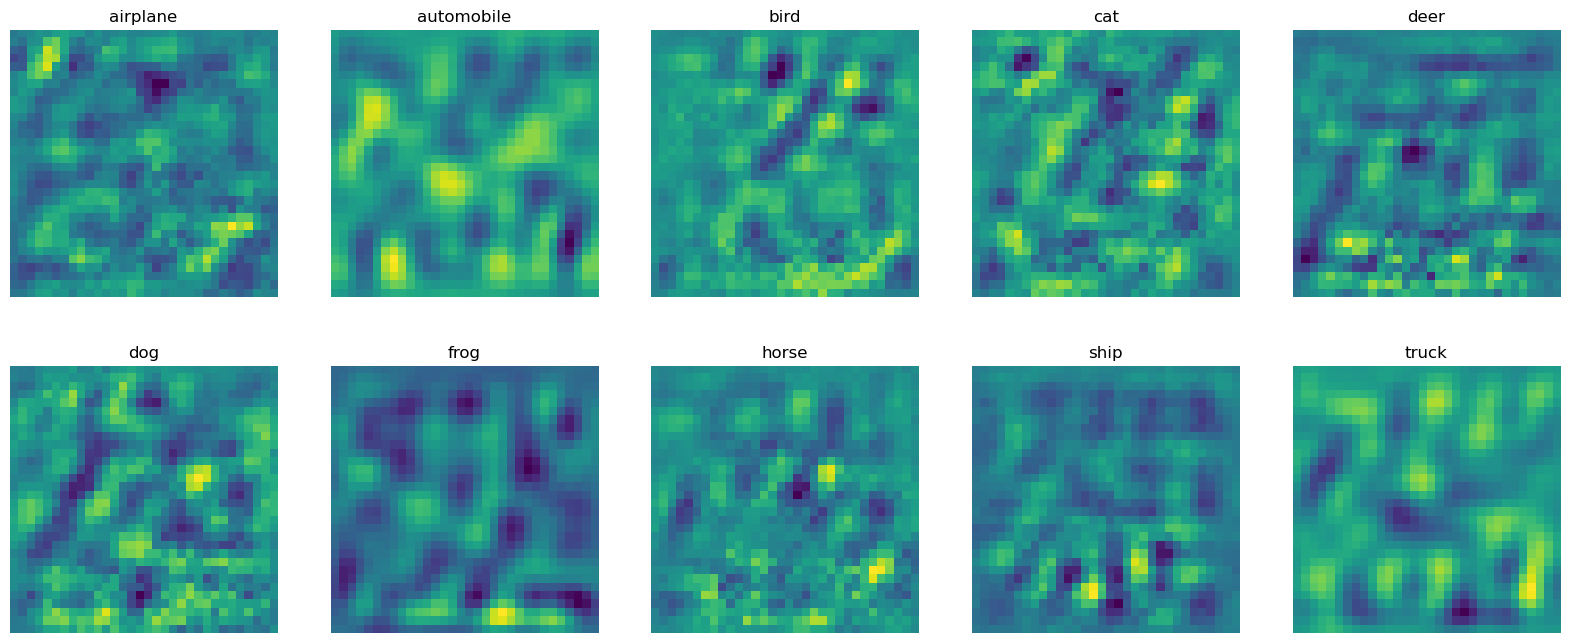

In [10]:
eff_rfs = effective_receptive_field(model, n_batch=2048, device=device)
fig, axes = plt.subplots(2, 5, figsize=(20,8))

for class_name, eff_rf, ax  in zip(train_data.classes, eff_rfs, axes.flat):
    ax.imshow(normalizeZeroOne(eff_rf.movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)